# Setup

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [24]:
data_orig = pd.read_csv("/Users/jmadu1/Documents/healthcare-dataset-stroke-data.csv")
data_orig

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [25]:
data = data_orig.copy()
data

,Unnamed: 0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [27]:
data = data.drop(columns='Unnamed: 0')
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [28]:
from sklearn.impute import SimpleImputer

# Instantiate a SimpleImputer object with your strategy of choice
imputer = SimpleImputer(strategy="mean") 

# Call the "fit" method on the object
imputer.fit(data[['bmi']]) 

# Call the "transform" method on the object
data['bmi'] = imputer.transform(data[['bmi']]) 

In [29]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


# pipeline

In [30]:
#declare X and y
X = data.drop(columns='stroke')
y = data['stroke']

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier

age_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# BMI PIPE
bmi_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

# GLUCOSE PIPE
glucose_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

#CATEGORICAL PIPE
categ_pipe = Pipeline([('cat_transformer', OneHotEncoder(handle_unknown='ignore'))])

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer([
        ("age_pipe", age_pipe, ["age"]),
        ("bmi_pipe", bmi_pipe, ["bmi"]),
        ("glucose_pipe", glucose_pipe, ["avg_glucose_level"]),
        ("categoricals", categ_pipe, ["ever_married","work_type","Residence_type","smoking_status","gender"])],
        remainder='passthrough')

pipeline = make_pipeline(final_preprocessor, LogisticRegression(n_jobs=-1, penalty='l2',solver='lbfgs', max_iter=1000))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('bmi_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('glucose_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['avg_glucose_level']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1))])

# Oversample

In [32]:
#train_test_split, then oversample training data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [33]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('bmi_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('glucose_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['avg_glucose_level']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1))])

In [34]:
from imblearn.over_sampling import SMOTEN
X_resampled, y_resampled = SMOTEN(sampling_strategy=0.8, random_state=5).fit_resample(X_train, y_train)


In [35]:
X_resampled

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Female,76.0,0,0,Yes,Govt_job,Urban,204.05,23.500000,never smoked
1,Female,79.0,0,1,Yes,Private,Urban,226.98,29.800000,never smoked
2,Female,43.0,0,0,No,Private,Urban,71.77,26.900000,never smoked
3,Female,69.0,0,0,Yes,Self-employed,Rural,110.96,25.900000,never smoked
4,Male,56.0,0,0,Yes,Private,Urban,82.64,31.000000,never smoked
...,...,...,...,...,...,...,...,...,...,...
6122,Female,79.0,0,0,Yes,Private,Rural,72.73,28.400000,never smoked
6123,Male,57.0,0,1,Yes,Private,Urban,74.10,28.300000,Unknown
6124,Female,78.0,0,0,Yes,Private,Rural,57.92,28.893237,never smoked
6125,Female,74.0,0,0,Yes,Private,Urban,57.92,28.893237,never smoked


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder 
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier

age_pipe = Pipeline([
    ('scaler', RobustScaler())
])

# BMI PIPE
bmi_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# GLUCOSE PIPE
glucose_pipe = Pipeline([
    ('scaler', RobustScaler())
])

#CATEGORICAL PIPE
categ_pipe = Pipeline([('cat_transformer', OneHotEncoder(handle_unknown='ignore'))])

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer([
        ("age_pipe", age_pipe, ["age"]),
        ("bmi_pipe", bmi_pipe, ["bmi"]),
        ("glucose_pipe", glucose_pipe, ["avg_glucose_level"]),
        ("categoricals", categ_pipe, ["ever_married","work_type","Residence_type","smoking_status","gender"])],
        remainder='passthrough')

pipeline = make_pipeline(final_preprocessor, LogisticRegression(n_jobs=-1, penalty='l2',solver='lbfgs', max_iter=1000))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age']),
                                                 ('bmi_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('glucose_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['avg_glucose_level']),
                                                 ('categoricals',
                                                  Pipeline(steps=[('cat_transformer',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, n_jobs=-1))])

# pipeline fit, predict, score

In [37]:
# Train Pipeline
pipeline.fit(X_resampled, y_resampled)

# Make predictions
pipeline.predict(X_test)

array([0, 1, 0, ..., 0, 1, 0])

In [38]:
# Score model
pipeline.score(X_test,y_test)

0.7677756033920418

In [39]:
from sklearn.model_selection import cross_val_score

# Cross-validate Pipeline
cross_val_score(pipeline,X_resampled, y_resampled, cv=5, scoring='recall').mean()

0.7958283864004317

In [40]:
y_resampled.value_counts(normalize=True)

0    0.555574
1    0.444426
Name: stroke, dtype: float64

# pickle pipeline

In [41]:
import pickle

# Export Pipeline as pickle file
with open("pipeline.pkl", "wb") as file:
    pickle.dump(pipeline, file)

# Load Pipeline from pickle file
my_pipeline = pickle.load(open("pipeline.pkl","rb"))

# Attempt 2 -- balance dataset, train_test_split, pipeline with LogisticRegression

In [32]:
data_processed = data
data_processed

,id,gender,age,ATP2B1,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,2,1,83.75,28.1,2,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1,0


In [33]:
data_processed.to_csv("/Users/jmadu1/Documents/healthcare-dataset-stroke-data-processed.csv")

In [34]:
df_processed_tester = pd.read_csv("/Users/jmadu1/Documents/healthcare-dataset-stroke-data-processed.csv")
df_processed_tester

,Unnamed: 0,id,gender,age,ATP2B1,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,1,51676,0,61.0,0,0,1,3,0,202.21,28.1,2,1
2,2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,5105,18234,0,80.0,1,0,1,2,1,83.75,28.1,2,0
5106,5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1,0


In [35]:
#declare X and y
X = data_processed.drop(columns='stroke')
y = data_processed['stroke']

In [36]:
#train_test_split, then oversample training data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [37]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy=0.8, random_state=5).fit_resample(X_train, y_train)

In [38]:
X_resampled

,id,gender,age,ATP2B1,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,40379,0,57.000000,0,0,1,2,0,98.570000,31.600000,2
1,45824,0,77.000000,1,0,1,3,1,102.010000,29.500000,0
2,57983,1,50.000000,0,0,1,0,1,227.890000,38.800000,1
3,27789,0,57.000000,0,0,1,2,1,73.000000,26.200000,2
4,170,1,43.000000,0,0,1,0,0,80.070000,28.100000,2
...,...,...,...,...,...,...,...,...,...,...,...
6111,16835,1,75.160502,0,0,0,2,1,113.706624,25.987649,1
6112,48349,0,69.905000,0,0,0,0,0,71.513136,29.268853,0
6113,38475,0,74.315206,0,0,1,2,0,78.152265,30.939767,1
6114,31545,0,38.308986,0,0,0,3,1,87.063099,25.730320,1


In [39]:
data_processed.smoking_status.value_counts()

2    1892
0    1544
1     885
3     789
Name: smoking_status, dtype: int64

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Impute then scale numerical values: 
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Parallelize "num_transformer" and "cat_transfomer"
#format here is name, variable, features to be applied to
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age', 'bmi','avg_glucose_level'])],
    remainder='passthrough'
)

#default Ridge estimator
pipeline = make_pipeline(preprocessor, KNeighborsClassifier(n_jobs=-1, n_neighbors=5))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

In [41]:
from sklearn.model_selection import cross_val_score

# Cross-validate Pipeline
cross_val_score(pipeline,X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

0.6664480891838883

In [42]:
y_resampled.value_counts(normalize=True)

0    0.555592
1    0.444408
Name: stroke, dtype: float64

In [43]:
# Train Pipeline
pipeline.fit(X_resampled, y_resampled)

# Make predictions
pipeline.predict(X_test)

array([1, 1, 0, ..., 0, 0, 0])

In [44]:
# Score model
pipeline.score(X_test,y_test)

0.6881930854533594

In [45]:
y_test.value_counts(normalize=True)

0    0.954338
1    0.045662
Name: stroke, dtype: float64

---

# side quest - randomsearch

## XGBoost vs KNClassifier

In [43]:
#hyperparams that may improve score with KNClassifier

# YOUR CODE BELOW
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

# Hyperparameter Grid - remember that all parameters (strategy, kernel, C) have to be called as pipeline's params
grid = {
    'n_neighbors': [1,2,5,10], 
    'n_jobs': [-1,1,2,3]
}

# Instantiate Grid Search - to detect what improves performance
search = GridSearchCV(
    model,
    grid, 
    scoring='accuracy',
    cv=5, n_jobs=-1
)

#fit the grid to the data
search.fit(X_resampled,y_resampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_jobs': [-1, 1, 2, 3], 'n_neighbors': [1, 2, 5, 10]},
             scoring='accuracy')

In [44]:
search.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [45]:
#hyperparams that may improve score with SVC

# YOUR CODE BELOW
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

model = SVC()

# Hyperparameter Grid - remember that all parameters (strategy, kernel, C) have to be called as pipeline's params
grid = {
    'kernel': ['poly','rbf','sigmoid'],
    'C': [5,10,15]
}

# Instantiate Grid Search - to detect what improves performance
search = RandomizedSearchCV(
    model,
    grid, 
    scoring='accuracy',
    n_iter=5000,  # number of draws
    cv=5, n_jobs=-1
)

#fit the grid to the data
search.fit(X_resampled,y_resampled)

/Users/jmadu1/.pyenv/versions/3.10.6/envs/lewagon_current/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=5000. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5000, n_jobs=-1,
                   param_distributions={'C': [5, 10, 15],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   scoring='accuracy')

In [46]:
search.best_estimator_

SVC(C=5, kernel='poly')

# Get feature names out

In [76]:
from sklearn.preprocessing import OneHotEncoder


gender_ohe = OneHotEncoder(sparse_output=False) # Instanciate One hot encoder

gender_ohe.fit(data[['gender']]) # Fit one hot encoder

gender_ohe.get_feature_names_out()

array(['gender_Female', 'gender_Male', 'gender_Other'], dtype=object)

In [77]:
from sklearn.preprocessing import OneHotEncoder


married_ohe = OneHotEncoder(sparse_output=False) # Instanciate One hot encoder

married_ohe.fit(data[['ever_married']]) # Fit one hot encoder

married_ohe.get_feature_names_out()

array(['ever_married_No', 'ever_married_Yes'], dtype=object)

In [78]:
from sklearn.preprocessing import OneHotEncoder


work_ohe = OneHotEncoder(sparse_output=False) # Instanciate One hot encoder

work_ohe.fit(data[['work_type']]) # Fit one hot encoder

work_ohe.get_feature_names_out()

array(['work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed',
       'work_type_children'], dtype=object)

In [79]:
from sklearn.preprocessing import OneHotEncoder


residence_ohe = OneHotEncoder(sparse_output=False) # Instanciate One hot encoder

residence_ohe.fit(data[['Residence_type']]) # Fit one hot encoder

residence_ohe.get_feature_names_out()

array(['Residence_type_Rural', 'Residence_type_Urban'], dtype=object)

In [80]:
from sklearn.preprocessing import OneHotEncoder


smoking_ohe = OneHotEncoder(sparse_output=False) # Instanciate One hot encoder

smoking_ohe.fit(data[['smoking_status']]) # Fit one hot encoder

smoking_ohe.get_feature_names_out()

array(['smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype=object)

# data viz for age and glucose level

<AxesSubplot:xlabel='age', ylabel='Count'>

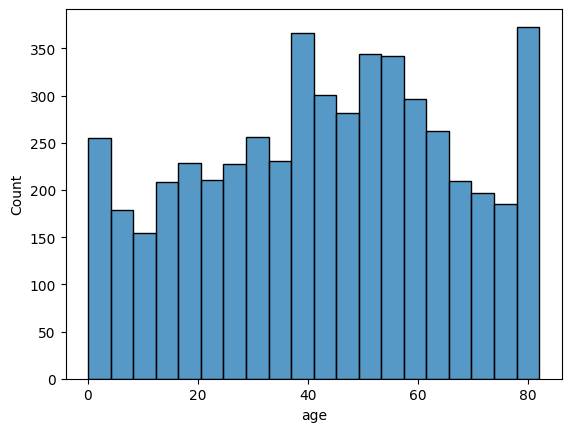

In [59]:
import seaborn as sns

sns.histplot(data.age)

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

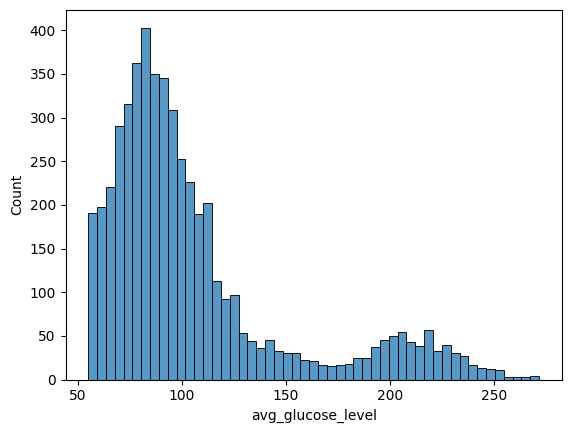

In [60]:
import seaborn as sns

sns.histplot(data.avg_glucose_level)

# Check for duplicates, null values and imbalances in target

In [61]:
print(f'The sum of all duplicated data is {data.duplicated().sum()}. \n')

print(f'Total null values per feature: \n {data.isnull().sum().sort_values(ascending=False)}')


The sum of all duplicated data is 0. 

Total null values per feature: 
 id                   0
gender               0
age                  0
ATP2B1               0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [62]:
print("Percentage of null values per feature: \n")
data.isnull().sum().sort_values(ascending=False)/len(data)


Percentage of null values per feature: 



id                   0.0
gender               0.0
age                  0.0
ATP2B1               0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64

In [63]:
#determine imbalances in target, if any (these affect results of dummy classifier)
data.stroke.value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

95% of targets in dataset show patients are not likely to have a stroke. not good as this means the model itself wont predict things very accurately. hence dummy classifier score being so high (it literally reflects the skew).

# Conduct dummy test for baseline score, cross validate baseline model

In [168]:
X = data.drop(columns='stroke')
y = data['stroke']

In [169]:
X

,id,gender,age,ATP2B1,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,2
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2
...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,2,1,83.75,28.1,2
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,2
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,2
5108,37544,1,51.0,0,0,1,2,0,166.29,25.6,1


In [170]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [172]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier()
baseline_model.fit(X_train, y_train)
baseline_model.score(X_test, y_test) 

0.9478147423352903

In [173]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(baseline_model, X, y, cv=5)

In [174]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.001954,0.000929,0.951076
1,0.000885,0.000642,0.951076
2,0.000851,0.000609,0.951076
3,0.000944,0.000627,0.951076
4,0.001112,0.000601,0.952055


# Attempt 1 -- Balance data, then make preprocessor, integrate model to create full pipeline

In [24]:
data.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [25]:
X = data.drop(columns='stroke')
y = data['stroke']

In [26]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [28]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(sampling_strategy=0.3, random_state=5).fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'smokes'

In [275]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test) 

0.9504240052185258

In [276]:
new_df = pd.DataFrame(X_resampled,y_resampled)
new_df

,id,gender,age,ATP2B1,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,,
0,34077,1,46.0,0,0,1,0,0,102.27,38.9,1
0,34077,1,46.0,0,0,1,0,0,102.27,38.9,1
1,1183,1,39.0,0,0,1,2,0,84.18,28.1,3
0,34077,1,46.0,0,0,1,0,0,102.27,38.9,1
0,34077,1,46.0,0,0,1,0,0,102.27,38.9,1
...,...,...,...,...,...,...,...,...,...,...,...
1,1183,1,39.0,0,0,1,2,0,84.18,28.1,3
1,1183,1,39.0,0,0,1,2,0,84.18,28.1,3
1,1183,1,39.0,0,0,1,2,0,84.18,28.1,3


In [277]:
new_df.heart_disease.value_counts()

0    4422
Name: heart_disease, dtype: int64

In [234]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

# Impute then scale numerical values: 
num_transformer = Pipeline([
    ('scaler', RobustScaler())
])

# Parallelize "num_transformer" and "cat_transfomer"
#format here is name, variable, features to be applied to
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age', 'bmi','avg_glucose_level'])],
    remainder='passthrough'
)

#default Ridge estimator
pipeline = make_pipeline(preprocessor, LogisticRegression())
pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'bmi',
                                                   'avg_glucose_level'])])),
                ('logisticregression', LogisticRegression())])

In [235]:
from sklearn.model_selection import cross_val_score

# Cross-validate Pipeline
cross_val_score(pipeline,X,y, cv=5, scoring='r2').mean()

-0.07645877372176288

In [236]:
# Train Pipeline
pipeline.fit(X_train,y_train)

# Make predictions
pipeline.predict(X_test)

# Score model
pipeline.score(X_test,y_test)

0.9530332681017613

In [204]:
new_df

,id,gender,age,ATP2B1,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,,
0,29232,0,56.0,0,0,1,2,1,114.33,30.7,3
0,29232,0,56.0,0,0,1,2,1,114.33,30.7,3
0,29232,0,56.0,0,0,1,2,1,114.33,30.7,3
0,29232,0,56.0,0,0,1,2,1,114.33,30.7,3
1,37053,1,53.0,0,0,1,0,0,78.73,23.3,2
...,...,...,...,...,...,...,...,...,...,...,...
1,37053,1,53.0,0,0,1,0,0,78.73,23.3,2
1,37053,1,53.0,0,0,1,0,0,78.73,23.3,2
1,37053,1,53.0,0,0,1,0,0,78.73,23.3,2
